Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from windrose import WindroseAxes
import folium

from datetime import date, timedelta, datetime
from joblib import Parallel, delayed
import pickle

# to suppress future warning 
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(style="whitegrid")
print('All libraries installed and imported')

All libraries installed and imported


In [2]:
include_WSPD = False

Loading buoys' characteristics, including the owner, latitue, longitude, year with yearly available data.

In [3]:
path_read = r'C:\Users\masou\Documents\Research\Ocean_Studies\Ocean_Data\Data\buoys_char.pkl'
a_file = open(path_read, "rb")
buoy_char = pickle.load(a_file)
a_file.close()
buoy_char

,Owner,Latitude,Longitude,1970,1971,1972,1973,1974,1975,1976,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Station_Name,,,,,,,,,,,,,,,,,,,,,
KECA2,NOS Stations,-131.625000,55.331001,None,None,None,None,None,None,None,...,1,1,1,1,1,1,1,1,1,1
BLTM2,NOS Stations,-76.578003,39.266998,None,None,None,None,None,None,None,...,1,1,1,1,1,1,1,1,1,1
GELO1,NWS Eastern Region Stations,-80.973999,41.860001,None,None,None,None,None,None,None,...,1,1,1,1,1,1,1,1,1,None
PSBC1,NOAA NOS PORTS Stations,-121.887001,38.042000,None,None,None,None,None,None,None,...,None,None,None,None,1,1,1,1,1,1
ARPF1,COMPS (University of South Florida) Stations,-82.667000,28.433001,None,None,None,None,None,None,None,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42058,National Data Buoy Center Stations,-74.917999,14.923000,None,None,None,None,None,None,None,...,1,None,1,1,1,1,1,1,1,1
OMHC1,NOAA NOS PORTS Stations,-122.330002,37.800999,None,None,None,None,None,None,None,...,1,1,1,1,1,1,1,1,1,1
TCNW1,NOAA NOS PORTS Stations,-122.413002,47.266998,None,None,None,None,None,None,None,...,1,1,1,1,1,1,1,1,1,1


Let's put all the data into one big dictionary with keys representing buoys. In this structure, the data is stored in a dataframe for each buoy for all the years

In [4]:
# reading pickle files
data_buoy = {}
years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
for year in years:
    path_read = f'C:/Users/masou/Documents/Research/Ocean_Studies/Ocean_Data/Data/{year}.pkl'
    a_file = open(path_read, "rb")
    output_file = pickle.load(a_file)
    
    #print(20*'-')
    #print(f'The data is for year {year}')
    #print(f'Data includes {len(output_file.keys())} number of stations')

    # re-sampling
    

    for buoy in output_file.keys():
        # (maybe in the future) re-sampling the data to 30 minute intervals
        output_file_temp_df = output_file[buoy]#.resample('30Min', on='DATE').mean().reset_index()
        try:
            data_buoy[buoy] = pd.concat([ data_buoy[buoy], output_file_temp_df], ignore_index=True)
        except:
            data_buoy[buoy] = output_file_temp_df


Now, we have `data_buoy` dictionary that includes all the data for all the buoys in the time range.

In [5]:
# print the number of buoys with at least one available data point in this time range
print(len(data_buoy.keys()))

798


As an example, we can look at the data for one of the buoys

In [6]:
# as an example, information for one buoy
buoy_sample = list(data_buoy.keys())[0]  # buoy number 0
print(f'data for buoy {buoy_sample}')
buoy_sample_char = buoy_char.loc[buoy_sample,:].dropna(how='all') # dropping all the rows with missing values

# getting latitude, longitude, owner, and the vailable available years of data
buoy_sample_lat = buoy_sample_char.loc['Latitude']
buoy_sample_lon = buoy_sample_char.loc['Longitude']
buoy_sample_owner = buoy_sample_char.loc['Owner']
buoy_sample_years = buoy_sample_char.iloc[3:].index[:] # available years

# printing the results
print(f'This buoy is owned by {buoy_sample_owner}. \nIt is located at lat={buoy_sample_lat:.3f} and Lon={buoy_sample_lon:.3f}')
print(f'It has data for years: {buoy_sample_years}')

# printing the data for the given buoy
data_buoy[buoy_sample]

data for buoy PTLA2
This buoy is owned by Marine Exchange of Alaska Stations. 
It is located at lat=-134.752 and Lon=58.346
It has data for years: Index([2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype='object')


,WDIR,WSPD,GST,PRES,ATMP,DEWP,DATE
0,160.0,1.5,2.6,NaN,5.6,-0.1,2012-12-31 23:00:00
1,170.0,1.5,2.1,NaN,5.2,-1.2,2012-12-31 22:00:00
2,150.0,2.1,4.1,NaN,3.9,-0.9,2012-12-31 21:00:00
3,160.0,2.6,4.1,NaN,2.7,-1.4,2012-12-31 20:00:00
4,160.0,1.5,2.6,NaN,4.2,-0.9,2012-12-31 19:00:00
...,...,...,...,...,...,...,...
232903,345.0,3.7,4.6,1006.6,1.7,0.5,2021-01-01 00:52:00
232904,350.0,3.9,4.8,1006.7,1.7,0.5,2021-01-01 00:42:00
232905,357.0,4.3,5.3,1006.9,1.7,0.5,2021-01-01 00:32:00
232906,353.0,4.7,5.8,1007.0,1.7,0.5,2021-01-01 00:22:00


## Data Preparation

Let's re-sample the data and then create a dataframe with rows representing the stations and columns representing daily values of wave hegith, wave period, and wind speed.

In [7]:
# making a copy
data_buoy_copy = data_buoy.copy()

data_wave_wind = {} # to keep only wave and wind data

# sampling frequency
data_frq = '5D'

for buoy in data_buoy_copy.keys():
    
    # resampling to get the average daily values
    #   - The origin is at the first day at midnight of the timeseries
    data_buoy_copy[buoy] = data_buoy_copy[buoy].resample(data_frq, closed='left', on='DATE').mean()
    data_buoy_copy[buoy].reset_index(inplace=True)

    # keeping only the buoys containing the wave and wind data
    try:
        data_wave_wind[buoy] = data_buoy_copy[buoy].loc[:, ['DATE', 'WVHT','APD','WSPD']]
    except:
        None

Looking at the data for one buoy

In [8]:
buoy_lookup_num = 1
buoy_lookup = list(data_wave_wind.keys())[buoy_lookup_num]
data_wave_wind[buoy_lookup]

,DATE,WVHT,APD,WSPD
0,2012-01-01,2.809174,6.715872,7.526087
1,2012-01-06,2.148333,6.581930,5.321667
2,2012-01-11,1.878198,5.664602,6.984167
3,2012-01-16,2.752966,6.720763,7.222500
4,2012-01-21,1.944018,5.885357,6.663866
...,...,...,...,...
726,2021-12-09,2.541833,6.555417,8.366385
727,2021-12-14,2.931333,6.876583,9.024028
728,2021-12-19,2.054706,6.204958,7.194715
729,2021-12-24,1.876500,7.407333,3.757917


Let's try to re-shape the data into something suitable for clustering purposes

In [9]:
# creating a time vector for the given date range
#start_date = '2012-01-01'
#end_date = '2021-12-31'
#dates = pd.date_range(start= start_date, end= end_date, freq=data_frq)
random_buoy = 1
dates = data_wave_wind[list(data_wave_wind.keys())[random_buoy]]['DATE']

# creating separate with station names as rows
data_clustering_WVHT = pd.DataFrame(columns=data_buoy_copy.keys()) #,index=dates)
data_clustering_APD = pd.DataFrame(columns=data_buoy_copy.keys()) #,index=dates)
data_clustering_WSPD = pd.DataFrame(columns=data_buoy_copy.keys()) #,index=dates)
#data_clustering = data_clustering.T


for buoy in data_wave_wind.keys():
    data_clustering_WVHT[buoy] = data_wave_wind[buoy].WVHT
    data_clustering_APD[buoy] = data_wave_wind[buoy].APD
    data_clustering_WSPD[buoy] = data_wave_wind[buoy].WSPD

# transposing to have stations as rows
data_clustering_WVHT = data_clustering_WVHT.T
data_clustering_WVHT.columns = dates#.date # only keeping the year-month-day data
data_clustering_WVHT.reset_index(inplace=True)
data_clustering_WVHT.rename(columns={'index':'station'}, inplace=True)

data_clustering_APD = data_clustering_APD.T
data_clustering_APD.columns = dates#.date # only keeping the year-month-day dat
data_clustering_APD.reset_index(inplace=True)
data_clustering_APD.rename(columns={'index':'station'}, inplace=True)

data_clustering_WSPD = data_clustering_WSPD.T
data_clustering_WSPD.columns = dates#.date # only keeping the year-month-day data
data_clustering_WSPD.reset_index(inplace=True)
data_clustering_WSPD.rename(columns={'index':'station'}, inplace=True);

Now we have three dataframes:
- `data_clustering_WVHT` : average daily wave height
- `data_clustering_APD`  : average daily wave period
- `data_clustering_WSPD` : average daily wind speed

In [10]:
# a quick look at the general form of one of the dataframes
data_clustering_WVHT.head()

DATE,station,2012-01-01 00:00:00,2012-01-06 00:00:00,2012-01-11 00:00:00,2012-01-16 00:00:00,2012-01-21 00:00:00,2012-01-26 00:00:00,2012-01-31 00:00:00,2012-02-05 00:00:00,2012-02-10 00:00:00,...,2021-11-14 00:00:00,2021-11-19 00:00:00,2021-11-24 00:00:00,2021-11-29 00:00:00,2021-12-04 00:00:00,2021-12-09 00:00:00,2021-12-14 00:00:00,2021-12-19 00:00:00,2021-12-24 00:00:00,2021-12-29 00:00:00
0,PTLA2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,42020,1.339652,1.342784,1.187315,1.368679,1.288559,1.226696,1.201802,1.798814,1.774727,...,1.114417,1.361583,1.6465,0.750167,0.938333,1.47325,1.226891,1.319083,1.494667,1.349583
2,41044,2.809174,2.148333,1.878198,2.752966,1.944018,1.953103,2.056441,2.573604,2.29178,...,2.199333,1.899417,2.09675,1.897167,1.842917,2.541833,2.931333,2.054706,1.8765,2.159792
3,44005,1.568051,1.12875,2.727586,1.829167,1.52725,1.862269,1.229,1.224538,1.63875,...,1.808833,1.756417,1.767,1.499917,1.768655,2.15175,1.61425,1.875,1.000504,0.855417
4,42047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# create a excel writer object
path_write = f'C:/Users/masou/Documents/Research/Ocean_Studies/Ocean_Data/Data/Wind_Wave_Data.xlsx'
with pd.ExcelWriter(path_write) as writer:
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    data_clustering_WVHT.to_excel(writer, sheet_name="wave_height", index=False)
    data_clustering_APD.to_excel(writer, sheet_name="wave_period", index=False)
    data_clustering_WSPD.to_excel(writer, sheet_name="wind_speed", index=False)

Let's now put all of them into a one big dataframe

In [28]:

# adding prefixes to distinguish the data for eaach feature
data_clustering_WVHT_prefixed = data_clustering_WVHT.add_prefix('WVHT_')
data_clustering_APD_prefixed = data_clustering_APD.add_prefix('APD_')
data_clustering_WSPD_prefixed = data_clustering_WSPD.add_prefix('WSPD_')

if include_WSPD == True:
    # putting all 3 dataframes into one dataframe
    data_clustering = pd.concat([data_clustering_WVHT_prefixed, data_clustering_APD_prefixed, data_clustering_WSPD_prefixed], axis=1)
    data_clustering.rename(columns={'WVHT_station':'station'}, inplace=True)
elif include_WSPD == False:
    # putting all 3 dataframes into one dataframe
    data_clustering = pd.concat([data_clustering_WVHT_prefixed, data_clustering_APD_prefixed], axis=1)
    data_clustering.rename(columns={'WVHT_station':'station'}, inplace=True)
# sanity check!
print(data_clustering_WVHT.shape, data_clustering_APD.shape, data_clustering_WSPD.shape)
print(data_clustering.shape)

# removing the rows with more than a certain percentage missing values
perc = 20.0
min_count =  int(((100-perc)/100)*data_clustering.shape[1] + 1)
data_clustering.dropna(axis=0, thresh=min_count, inplace=True)
print(data_clustering.shape)
data_clustering.head()

(798, 732) (798, 732) (798, 732)
(798, 1464)
(54, 1464)


DATE,station,WVHT_2012-01-01 00:00:00,WVHT_2012-01-06 00:00:00,WVHT_2012-01-11 00:00:00,WVHT_2012-01-16 00:00:00,WVHT_2012-01-21 00:00:00,WVHT_2012-01-26 00:00:00,WVHT_2012-01-31 00:00:00,WVHT_2012-02-05 00:00:00,WVHT_2012-02-10 00:00:00,...,APD_2021-11-14 00:00:00,APD_2021-11-19 00:00:00,APD_2021-11-24 00:00:00,APD_2021-11-29 00:00:00,APD_2021-12-04 00:00:00,APD_2021-12-09 00:00:00,APD_2021-12-14 00:00:00,APD_2021-12-19 00:00:00,APD_2021-12-24 00:00:00,APD_2021-12-29 00:00:00
1,42020,1.339652,1.342784,1.187315,1.368679,1.288559,1.226696,1.201802,1.798814,1.774727,...,4.2935,5.018417,4.892833,4.412167,4.393917,4.856917,4.723866,4.749333,4.96175,5.755208
2,41044,2.809174,2.148333,1.878198,2.752966,1.944018,1.953103,2.056441,2.573604,2.29178,...,6.402833,6.785417,7.377333,6.800667,6.463167,6.555417,6.876583,6.204958,7.407333,7.562917
9,46053,1.433846,1.735812,0.989083,1.177542,2.121429,1.308571,1.30188,1.618667,2.06055,...,6.850333,5.4185,6.953333,7.586,5.97225,5.605583,6.679748,7.715333,5.468,4.435
20,46025,1.169915,1.38675,0.898833,0.911667,1.684661,1.100504,0.94325,1.417479,2.043277,...,6.743583,5.654,5.949583,7.29175,6.08,NaN,5.643973,6.603083,5.321083,4.786667
27,46047,2.139831,2.894407,1.842083,2.22,3.122348,2.57313,2.104052,2.532083,3.141739,...,7.344833,6.338333,7.678333,8.58625,7.047083,7.663917,8.29925,8.98563,7.619917,6.703542


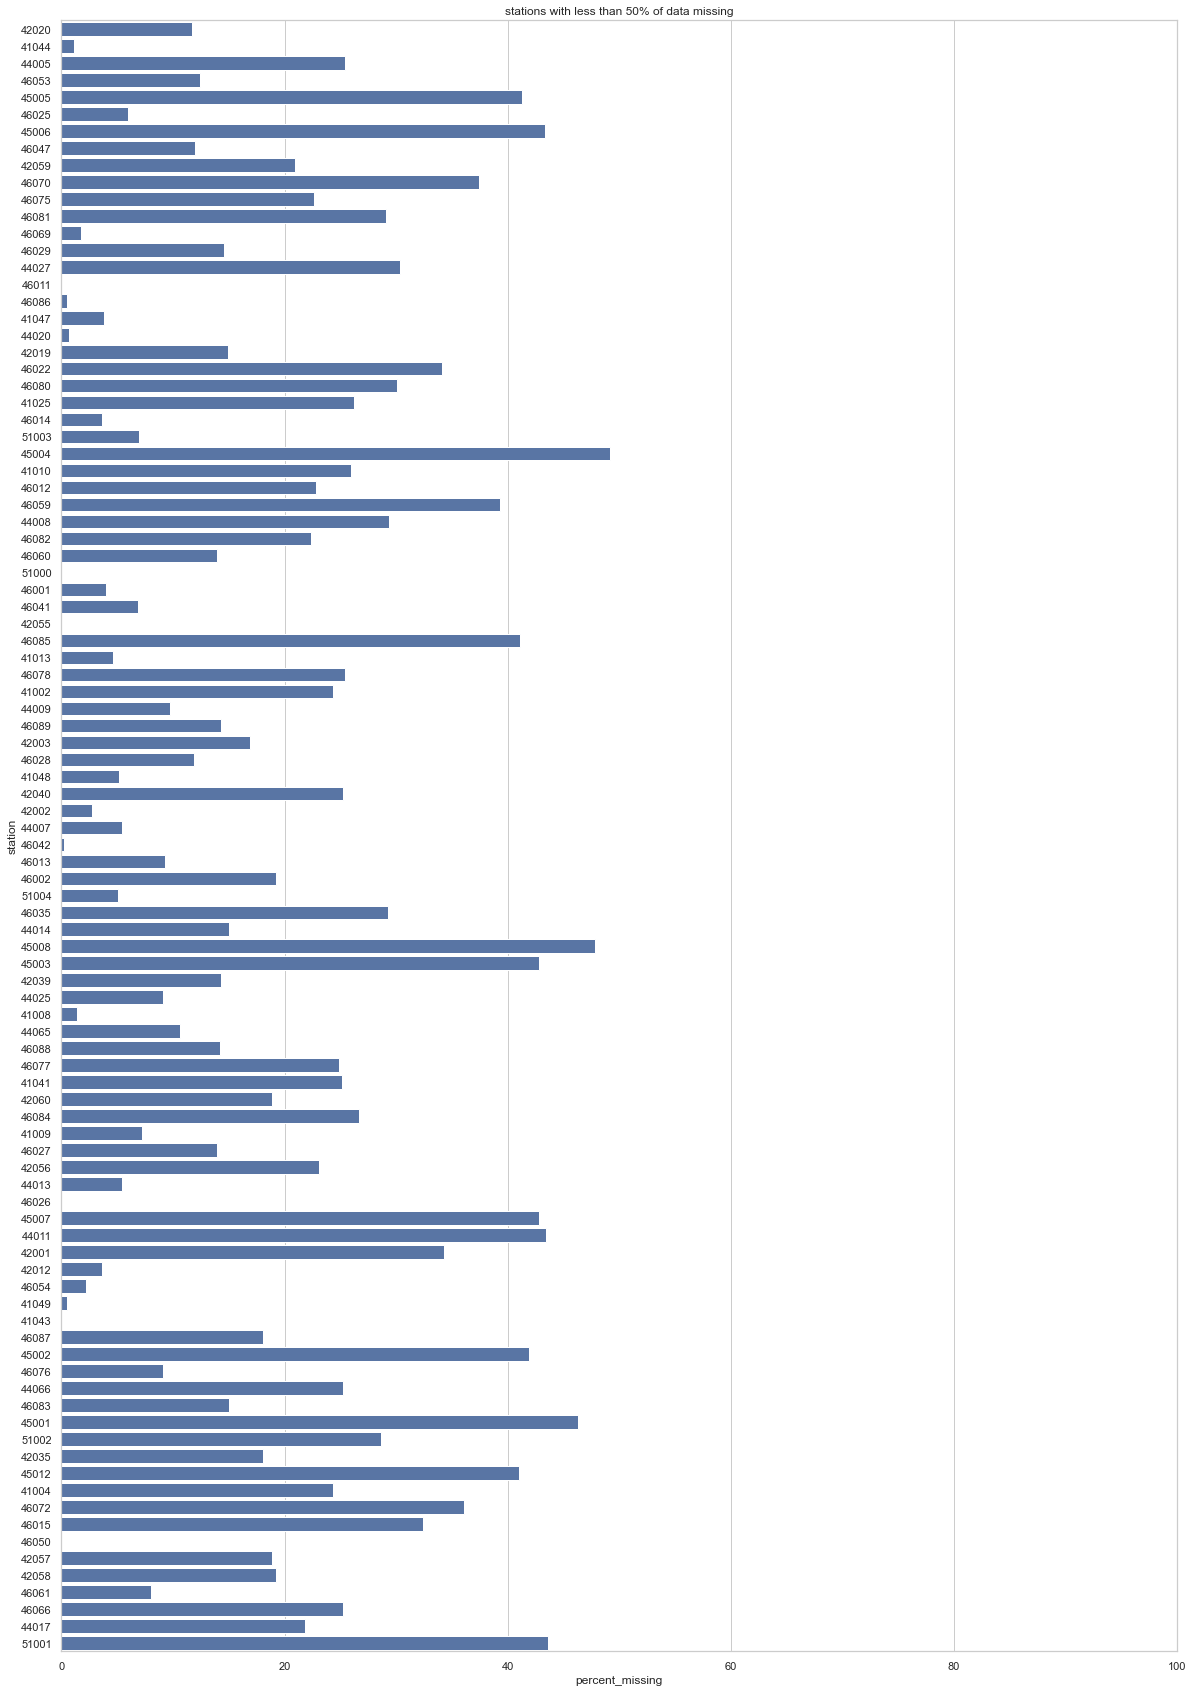

In [25]:
null_per_row = data_clustering.isnull().sum(axis=1)
data_no_null_df= pd.concat([data_clustering['station'], null_per_row], axis=1)
data_no_null_df.columns=['station', '# of NaNs']
data_no_null_df['percent_missing'] = (data_no_null_df['# of NaNs']/data_clustering.shape[1]) * 100

plt.figure(figsize=(20, 30))
sns.barplot(data=data_no_null_df, y='station', x='percent_missing', color='b')
plt.xlim([0,100])
plt.title(f"stations with less than {perc:.0f}% of data missing");

Let's see where these stations are on the map

In [26]:
def BuoyLocationPlot(buoys,MapInput,DataFrameInput,colorm,fill_colorm,Marker=False):
    
    # loop through and add each to the feature group
    for lat, lng, label in zip(DataFrameInput.Longitude, DataFrameInput.Latitude, DataFrameInput.station):
        buoys.add_child(
            folium.CircleMarker(
                [lat, lng],
                radius=6, # define how big you want the circle markers to be
                color=colorm,
                fill=True,
                fill_color=fill_colorm,
                fill_opacity=0.8,
                popup=label
            )
        )

    
    if Marker==True:
        latitudes = list(DataFrameInput.Longitude)
        longitudes = list(DataFrameInput.Latitude)
        labels = list(DataFrameInput.Station_Name)
        for lat, lng, label in zip(latitudes, longitudes, labels):
            folium.Marker([lat, lng], popup=label).add_to(MapInput)    
    
    
    return buoys

In [27]:
import matplotlib

# stations with less than `perc` missing values with info regarding the locations and owners
data_no_null_df_char = pd.merge(data_no_null_df, buoy_char, how='left', left_on='station', right_on='Station_Name').loc[:,'station':'Longitude']

figmp = folium.Figure(width=1300, height=700)
WorldMap_map_sta = folium.Map(location=[17.6078, -8.0817],tiles="Stamen Toner",zoom_start=2).add_to(figmp)
list_of_owners = data_no_null_df_char['Owner']#.value_counts()[0]
color=iter(plt.cm.rainbow(np.linspace(0,1, len(list_of_owners))))
for indx,owner in enumerate(list_of_owners):
    clr=matplotlib.colors.to_hex(next(color))
    feature_group = folium.map.FeatureGroup(name=owner)
    df_tmp = data_no_null_df_char[data_no_null_df_char['Owner']==owner]
    buoys=BuoyLocationPlot(feature_group,WorldMap_map_sta,df_tmp,clr,clr)
    WorldMap_map_sta.add_child(buoys,name=owner,index=indx)
    
folium.TileLayer("Stamen Toner").add_to(WorldMap_map_sta) 
folium.TileLayer("OpenStreetMap").add_to(WorldMap_map_sta) 
folium.TileLayer("Stamen Terrain").add_to(WorldMap_map_sta)
WorldMap_map_sta.add_child(folium.map.LayerControl())
WorldMap_map_sta

Let's remove the stations that are not in the US coastal regions

In [245]:
not_wanted_stations = ['46070', '45012', '45005', '45008', '45003', '45002', '45007', '45001', '45004', '45006']
data_no_null_df_final = data_no_null_df[~data_no_null_df['station'].isin(not_wanted_stations)]

In [246]:
# stations with less than `perc` missing values with info regarding the locations and owners
data_no_null_df_char = pd.merge(data_no_null_df_final, buoy_char, how='left', left_on='station', right_on='Station_Name').loc[:,'station':'Longitude']

figmp = folium.Figure(width=1300, height=700)
WorldMap_map_sta = folium.Map(location=[17.6078, -8.0817],tiles="Stamen Toner",zoom_start=2).add_to(figmp)
list_of_owners = data_no_null_df_char['Owner']#.value_counts()[0]
color=iter(plt.cm.rainbow(np.linspace(0,1, len(list_of_owners))))
for indx,owner in enumerate(list_of_owners):
    clr=matplotlib.colors.to_hex(next(color))
    feature_group = folium.map.FeatureGroup(name=owner)
    df_tmp = data_no_null_df_char[data_no_null_df_char['Owner']==owner]
    buoys=BuoyLocationPlot(feature_group,WorldMap_map_sta,df_tmp,clr,clr)
    WorldMap_map_sta.add_child(buoys,name=owner,index=indx)
    
folium.TileLayer("Stamen Toner").add_to(WorldMap_map_sta) 
folium.TileLayer("OpenStreetMap").add_to(WorldMap_map_sta) 
folium.TileLayer("Stamen Terrain").add_to(WorldMap_map_sta)
WorldMap_map_sta.add_child(folium.map.LayerControl())
WorldMap_map_sta

Let's create the final dataset with information we want and the stations we are interested in

(86, 1469)


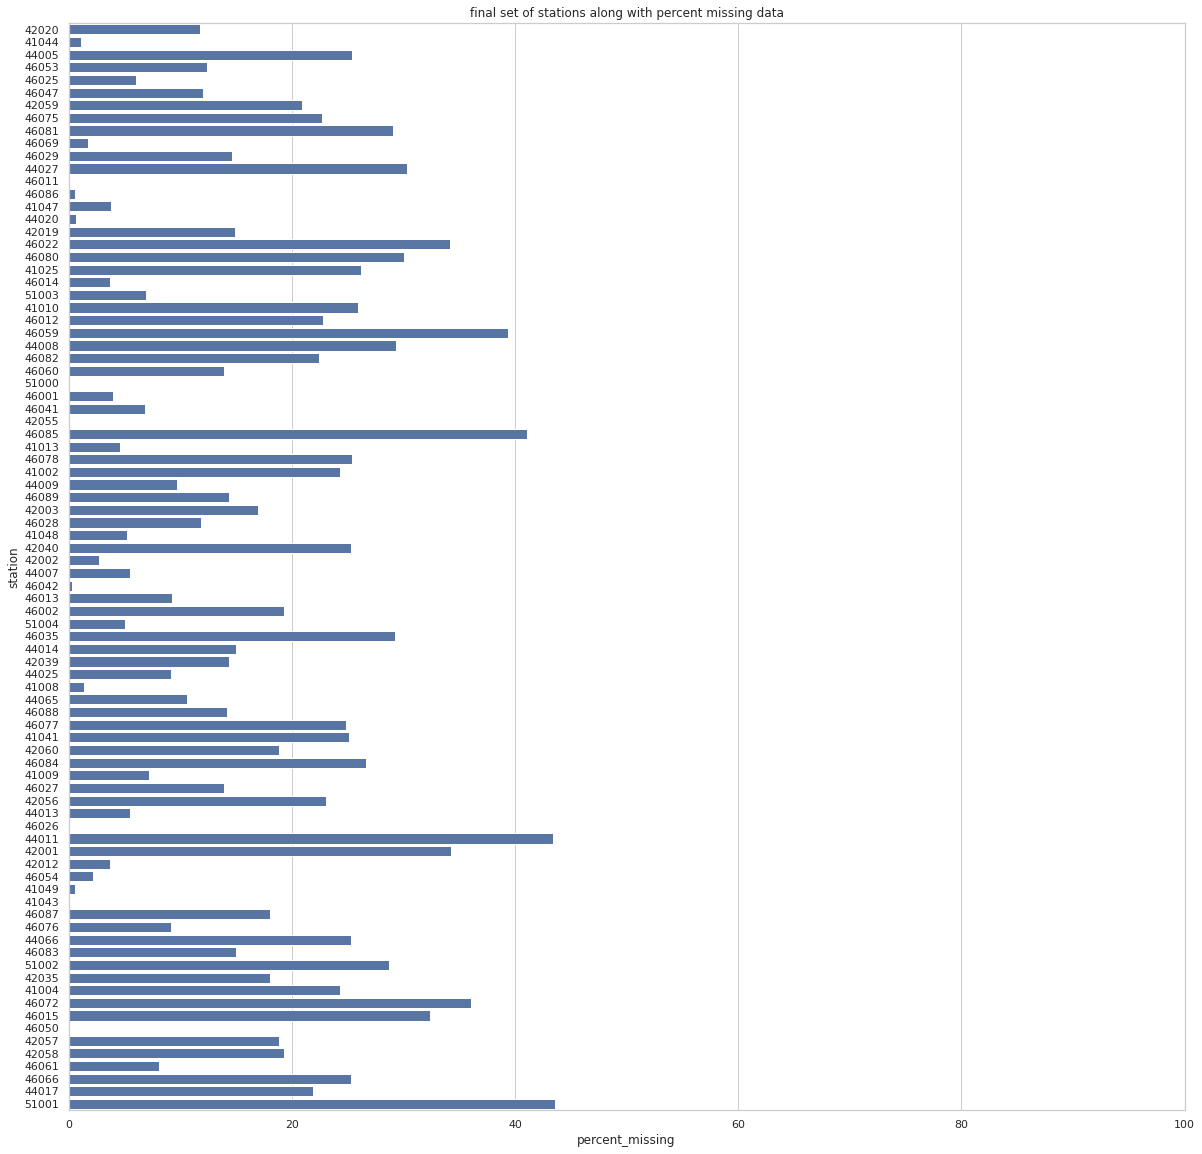

In [247]:
data_clustering_final = pd.merge(data_no_null_df_char, data_clustering, how='left', on='station')
# sanity check
print(data_clustering_final.shape)
# checking the missing values, again
plt.figure(figsize=(20, 20))
sns.barplot(data=data_clustering_final, y='station', x='percent_missing', color='b')
plt.xlim([0,100])
plt.title(f"final set of stations along with percent missing data");

In [248]:
#features = data_clustering_final.iloc[:,~data_clustering_final.columns.isin(['# of NaNs', 'percent_missing', 'Owner', 'Latitude', 'Longitude'])]

features = data_clustering_final.iloc[:,~data_clustering_final.columns.isin(['# of NaNs', 'percent_missing', 'Owner'])] #, 'Latitude', 'Longitude'])]

print(features.shape)
features.head()

(86, 1466)


,station,Latitude,Longitude,WVHT_2012-01-01 00:00:00,WVHT_2012-01-06 00:00:00,WVHT_2012-01-11 00:00:00,WVHT_2012-01-16 00:00:00,WVHT_2012-01-21 00:00:00,WVHT_2012-01-26 00:00:00,WVHT_2012-01-31 00:00:00,...,APD_2021-11-14 00:00:00,APD_2021-11-19 00:00:00,APD_2021-11-24 00:00:00,APD_2021-11-29 00:00:00,APD_2021-12-04 00:00:00,APD_2021-12-09 00:00:00,APD_2021-12-14 00:00:00,APD_2021-12-19 00:00:00,APD_2021-12-24 00:00:00,APD_2021-12-29 00:00:00
0,42020,-96.694000,26.968000,1.339652,1.342784,1.187315,1.368679,1.288559,1.226696,1.201802,...,4.2935,5.018417,4.892833,4.412167,4.393917,4.856917,4.723866,4.749333,4.96175,5.755208
1,41044,-58.613998,21.639000,2.809174,2.148333,1.878198,2.752966,1.944018,1.953103,2.056441,...,6.402833,6.785417,7.377333,6.800667,6.463167,6.555417,6.876583,6.204958,7.407333,7.562917
2,44005,-69.127998,43.203999,1.568051,1.12875,2.727586,1.829167,1.52725,1.862269,1.229,...,5.1825,4.980667,5.250083,4.896333,5.159412,5.550417,4.810917,5.10725,4.304034,4.575417
3,46053,-119.841003,34.248001,1.433846,1.735812,0.989083,1.177542,2.121429,1.308571,1.30188,...,6.850333,5.4185,6.953333,7.586,5.97225,5.605583,6.679748,7.715333,5.468,4.435
4,46025,-119.053001,33.749001,1.169915,1.38675,0.898833,0.911667,1.684661,1.100504,0.94325,...,6.743583,5.654,5.949583,7.29175,6.08,NaN,5.643973,6.603083,5.321083,4.786667


In [249]:
if include_WSPD == True:
    features.drop(columns=['WSPD_station', 'APD_station'], inplace=True)
elif include_WSPD == False:
    features.drop(columns=['APD_station'], inplace=True)

/tmp/ipykernel_226868/3473648153.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop(columns=['APD_station'], inplace=True)


In [250]:
features[features.columns[~features.columns.isin(['station'])]]=features[features.columns[~features.columns.isin(['station'])]].apply(pd.to_numeric, errors='coerce')

/tmp/ipykernel_226868/1464361979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[features.columns[~features.columns.isin(['station'])]]=features[features.columns[~features.columns.isin(['station'])]].apply(pd.to_numeric, errors='coerce')


### Missing Values

using the same day from a different year + padding

In [251]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# NOTE: dataframe with no filling is "features"
# NOTE: Check the output results to make sure it does what it is supposed to be doing!

def filling_NaNs(features_in, data_names, years, direction='forward'):
    #Nrows = features_in.shape[0]
    #Ncols = features_in.shape[1]
    
    
    for data_name in data_names:
        for year in years:
            
            year1 = year
            start_column_name1 = [s for s in features_in.columns if str(data_name)+'_'+str(year1) in s][0]
            end_column_name1 = [s for s in features_in.columns if str(data_name)+'_'+str(year1) in s][-1]
            print(start_column_name1, end_column_name1)
            
            df_tmp_1 = features_in.loc[0:,start_column_name1:end_column_name1]
            df_tmp_1.columns = df_tmp_1.columns.str.lstrip(data_name+'_'+str(year1))

            if direction == 'forward':
                year2 = year+1
            elif direction == 'backward':
                year2 = year-1
            start_column_name2 = [s for s in features_in.columns if str(data_name)+'_'+str(year2) in s][0]
            end_column_name2 = [s for s in features_in.columns if str(data_name)+'_'+str(year2) in s][-1]
            print(start_column_name2, end_column_name2)

            df_tmp_2 = features_in.loc[0:,start_column_name2:end_column_name2]
            
            df_tmp_2.columns = df_tmp_2.columns.str.lstrip(data_name+'_'+str(year2))

            # replacing the missing values in dataframe 1 with values for the same days from the next dataframe, i.e. df_tmp_2
            mask = df_tmp_1.astype(str) == 'nan'
            print(f'number of missing values before replacing {df_tmp_1.isnull().sum().sum()}')
            df_tmp_1.mask(mask, df_tmp_2, inplace=True)
            print(f'number of missing values after replacing {df_tmp_1.isnull().sum().sum()}')
            
            # adding the prefix to the column names so we can merge it with the final dataframe, i.e. features_final
            df_tmp_1 = df_tmp_1.add_prefix(str(data_name)+'_'+str(year1))


            if (year == years[0] and data_name == data_names[0]):
                features_final = pd.DataFrame(np.empty((df_tmp_1.shape[0], df_tmp_1.shape[1])) * np.nan, columns=df_tmp_1.columns)
            elif ~df_tmp_1.columns.isin(features_final.columns).any():
                features_final = features_final.reindex(columns = features_final.columns.tolist() + df_tmp_1.columns.tolist())

            features_final.loc[:,df_tmp_1.columns[0]:df_tmp_1.columns[-1]] = df_tmp_1.loc[:,start_column_name1:end_column_name1]
            print(20*'-')

        # taking care of the last year of the data - replacing its missing values using the first year in the data
        print('Taking care of the last year...')
        start_column_name_fistyear = [s for s in features_in.columns if str(data_name)+'_'+str(years[0]) in s][0]
        end_column_name_fistyear = [s for s in features_in.columns if str(data_name)+'_'+str(years[0]) in s][-1]
        print(start_column_name_fistyear, end_column_name_fistyear)

        df_tmp_firstyear = features_in.loc[0:,start_column_name_fistyear:end_column_name_fistyear]
        df_tmp_firstyear.columns = df_tmp_firstyear.columns.str.lstrip(data_name+'_'+str(years[0]))

        df_tmp_lastyear = df_tmp_2.copy()
        print(start_column_name2, end_column_name2)
        
        mask = df_tmp_lastyear.astype(str) == 'nan'
        print(f'number of missing values before replacing {df_tmp_lastyear.isnull().sum().sum()}')
        df_tmp_lastyear.mask(mask, df_tmp_firstyear, inplace=True)
        print(f'number of missing values after replacing {df_tmp_lastyear.isnull().sum().sum()}')
        

        df_tmp_lastyear = df_tmp_lastyear.add_prefix(str(data_name)+'_'+str(year2))

        if ~df_tmp_lastyear.columns.isin(features_final.columns).any():
                features_final = features_final.reindex(columns = features_final.columns.tolist() + df_tmp_lastyear.columns.tolist())

        features_final.loc[:,start_column_name2:end_column_name2] = df_tmp_lastyear.loc[:,start_column_name2:end_column_name2]
        
        print(50*'-')
        print(f'End of loop for {data_name}')
        print(50*'-')
        
    print(f'number of missing values in total before and after\n before:{features_in.isnull().sum().sum()}\n after: {features_final.isnull().sum().sum()}')

    return features_final


Doing the NaN value replacement `forward` or `backward` gives us the same number of remaining missing values. However, doing it _forward_ once and then doing the _backward_ results in much less number of missing values. That's what I did next.

In [252]:
# forward filling - using the year after to fill the missing value
if include_WSPD==True:
    data_names = ['WVHT', 'APD', 'WSPD']
elif include_WSPD==False:
    data_names = ['WVHT', 'APD']
    
years_1 = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]  
dataset_1 = filling_NaNs(features, data_names, years_1, direction='forward')

# backward filling - using the year before to fill the missing value
years_2 = [2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013]
dataset_2 = filling_NaNs(dataset_1, data_names, years_2, direction='backward')

# add the stations name to the dataframe
dataset_2['station'] = data_no_null_df_char['station']

# including latitude and longitude for each station as features
dataset_final = dataset_2.merge(features.loc[:,'station':'Longitude'], on='station', copy=False)
#dataset_final.drop(columns=['Latitude_x', 'Longitude_x'], inplace=True)
#dataset_final.rename(columns={'Latitude_y':'Latitude', 'Longitude_y':'Longitude'}, inplace=True)

# drop columns with all missing values
dataset_final.dropna(how="all", axis=1, inplace=True)

dataset_final.head()

WVHT_2012-01-01 00:00:00 WVHT_2012-12-31 00:00:00
WVHT_2013-01-05 00:00:00 WVHT_2013-12-31 00:00:00
number of missing values before replacing 904
number of missing values after replacing 375
--------------------
WVHT_2013-01-05 00:00:00 WVHT_2013-12-31 00:00:00
WVHT_2014-01-05 00:00:00 WVHT_2014-12-31 00:00:00
number of missing values before replacing 1349
number of missing values after replacing 488
--------------------
WVHT_2014-01-05 00:00:00 WVHT_2014-12-31 00:00:00
WVHT_2015-01-05 00:00:00 WVHT_2015-12-31 00:00:00
number of missing values before replacing 1180
number of missing values after replacing 173
--------------------
WVHT_2015-01-05 00:00:00 WVHT_2015-12-31 00:00:00
WVHT_2016-01-05 00:00:00 WVHT_2016-12-30 00:00:00
number of missing values before replacing 638
number of missing values after replacing 520
--------------------
WVHT_2016-01-05 00:00:00 WVHT_2016-12-30 00:00:00
WVHT_2017-01-04 00:00:00 WVHT_2017-12-30 00:00:00
number of missing values before replacing 591
numb

,WVHT_2021-01-03 00:00:00,WVHT_2021-01-08 00:00:00,WVHT_2021-01-13 00:00:00,WVHT_2021-01-18 00:00:00,WVHT_2021-01-23 00:00:00,WVHT_2021-01-28 00:00:00,WVHT_2021-02-02 00:00:00,WVHT_2021-02-07 00:00:00,WVHT_2021-02-12 00:00:00,WVHT_2021-02-17 00:00:00,...,APD_2012-12-01 00:00:00,APD_2012-12-06 00:00:00,APD_2012-12-11 00:00:00,APD_2012-12-16 00:00:00,APD_2012-12-21 00:00:00,APD_2012-12-26 00:00:00,APD_2012-12-31 00:00:00,station,Latitude,Longitude
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.897250,4.968167,4.639750,4.981345,4.880000,5.050427,5.257815,42020,-96.694000,26.968000
1,1.897250,1.966167,1.603750,1.858750,2.236250,2.797083,2.664333,1.94525,2.351917,2.268136,...,5.728205,5.864167,6.158522,6.457143,8.101167,5.530917,7.514706,41044,-58.613998,21.639000
2,2.609583,1.325667,1.767731,1.269000,1.610833,1.896000,3.025000,1.39075,1.106218,1.609580,...,4.718167,4.940084,5.360128,NaN,NaN,NaN,NaN,44005,-69.127998,43.203999
3,2.147167,2.110000,1.934370,1.549083,1.870333,1.328583,1.089412,0.74475,1.800833,1.554915,...,8.507417,6.133000,6.549298,6.924779,8.370504,7.164955,8.375214,46053,-119.841003,34.248001
4,1.611333,1.522667,1.280333,1.286500,1.799417,1.327667,0.977333,0.76650,1.735083,1.463390,...,6.774068,6.064750,5.582583,5.583193,7.186271,6.764454,7.318644,46025,-119.053001,33.749001


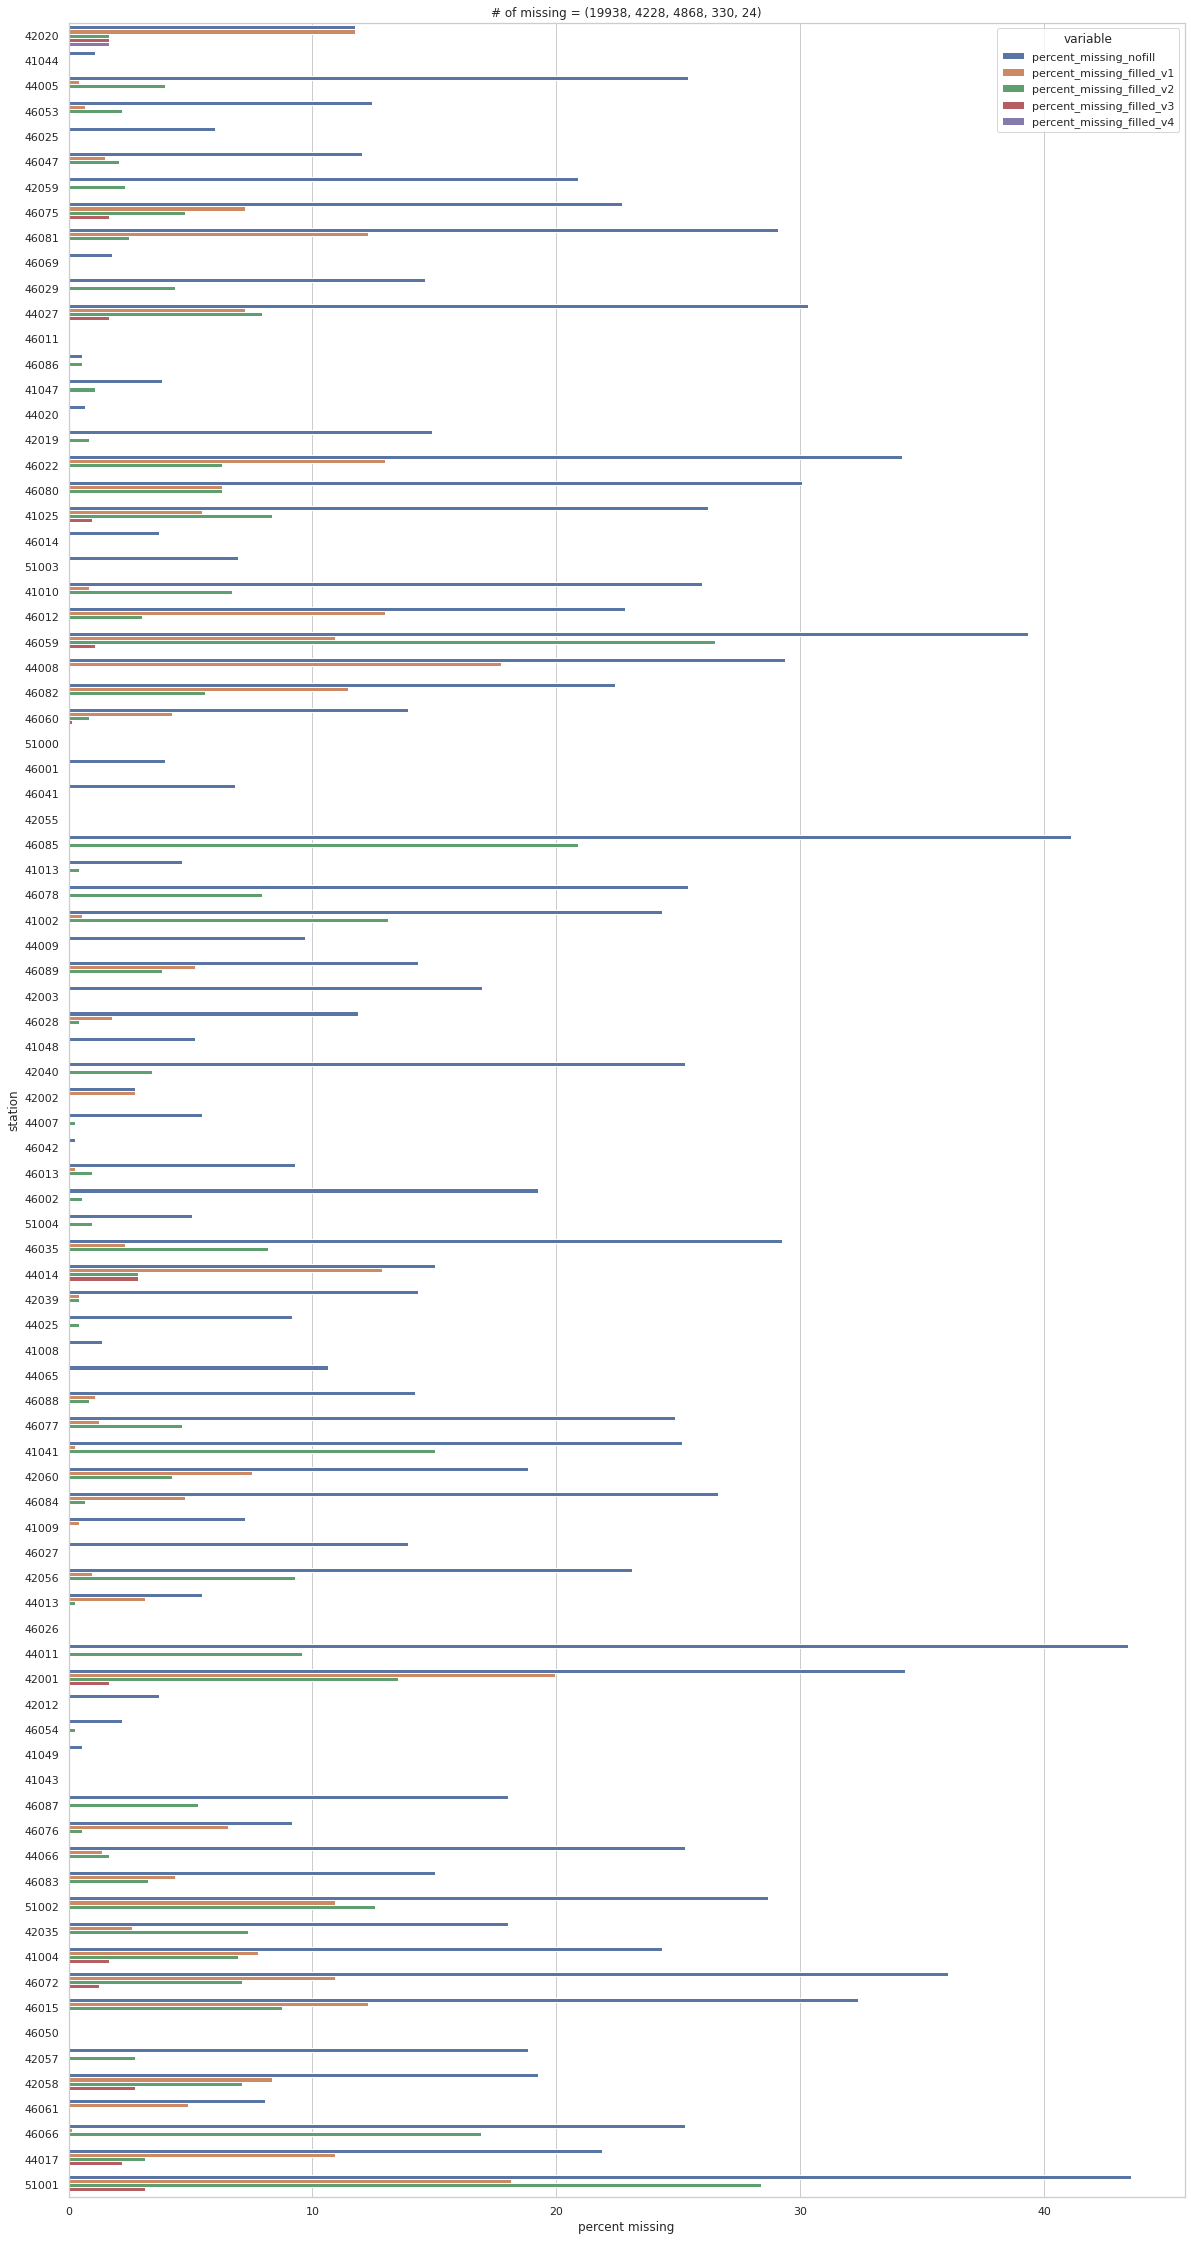

In [253]:
data_no_null_df_v0 = data_no_null_df.drop(columns=['# of NaNs'])
data_no_null_df_v0.rename(columns={'percent_missing':'percent_missing_nofill'}, inplace=True) 

# dealing with missing values
features_v1 = features.interpolate(method='pad', limit=1, axis=0)  # padding - no previous year replacing
features_v2 = dataset_final # replacing with values for next year and then with the previous year if the values is still missing
features_v3 = dataset_final.interpolate(method='pad', limit=1, axis=0) # padding after replacing
features_v4 = dataset_final.interpolate(method='pad', limit=3, axis=0) # padding after replacing

# calculating the percentage of missing data 
null_per_row_v1 = features_v1.isnull().sum(axis=1)
data_no_null_df_v1= pd.concat([features_v1['station'], null_per_row_v1], axis=1)
data_no_null_df_v1.columns=['station', '# of NaNs']
#--
null_per_row_v2 = features_v2.isnull().sum(axis=1)
data_no_null_df_v2= pd.concat([features_v2['station'], null_per_row_v2], axis=1)
data_no_null_df_v2.columns=['station', '# of NaNs']
#--
null_per_row_v3 = features_v3.isnull().sum(axis=1)
data_no_null_df_v3= pd.concat([features_v3['station'], null_per_row_v3], axis=1)
data_no_null_df_v3.columns=['station', '# of NaNs']
#--
null_per_row_v4 = features_v4.isnull().sum(axis=1)
data_no_null_df_v4= pd.concat([features_v4['station'], null_per_row_v4], axis=1)
data_no_null_df_v4.columns=['station', '# of NaNs']


data_no_null_df_v1['percent_missing_filled_v1'] = (data_no_null_df_v1['# of NaNs']/features_v1.shape[1]) * 100
data_no_null_df_v2['percent_missing_filled_v2'] = (data_no_null_df_v2['# of NaNs']/features_v2.shape[1]) * 100
data_no_null_df_v3['percent_missing_filled_v3'] = (data_no_null_df_v3['# of NaNs']/features_v3.shape[1]) * 100
data_no_null_df_v4['percent_missing_filled_v4'] = (data_no_null_df_v4['# of NaNs']/features_v4.shape[1]) * 100


data_no_null_df_v1.drop(columns=['# of NaNs'], inplace=True)
data_no_null_df_v2.drop(columns=['# of NaNs'], inplace=True)
data_no_null_df_v3.drop(columns=['# of NaNs'], inplace=True)
data_no_null_df_v4.drop(columns=['# of NaNs'], inplace=True)

# merging with previous on
null_per_row_mrg = pd.merge( pd.merge( pd.merge( pd.merge(data_no_null_df_v0, data_no_null_df_v1, on='station'), data_no_null_df_v2, on='station'), data_no_null_df_v3, on='station'), data_no_null_df_v4, on='station')

tidy = null_per_row_mrg.melt(id_vars='station').rename(columns=str)


plt.figure(figsize=(20, 40))
sns.barplot(y='station', x='value', hue='variable', data=tidy)
plt.xlabel('percent missing')
num_missing_val0 = features.isnull().sum().sum()
num_missing_val1 = features_v1.isnull().sum().sum()
num_missing_val2 = features_v2.isnull().sum().sum()
num_missing_val3 = features_v3.isnull().sum().sum()
num_missing_val4 = features_v4.isnull().sum().sum()
plt.title(f"# of missing = {num_missing_val0, num_missing_val1, num_missing_val2, num_missing_val3, num_missing_val4}");
#plt.legend(['No filling', 'padding', 'previous year'], loc='best')


In [254]:
# removing the only station with missing values
features_v4 = features_v4[features_v4['station']!="42020"]

percent_missing_total = features_v4.isnull().sum().sum()/features_v4.shape[1] * 100
print(f'percent of missing values in the dataset = {percent_missing_total:0.5f}%')

percent of missing values in the dataset = 0.00000%


In [255]:
# shape of the dataset
print( features_v4.shape )

# 
features_v5 = features_v4.dropna(how="any", axis=1)
percent_missing_total_2 = features_v5.isnull().sum().sum()/features_v5.shape[1] * 100
print(f'percent of missing values in the dataset = {percent_missing_total_2:0.5f}%')
print( features_v5.shape )

(85, 1465)
percent of missing values in the dataset = 0.00000%
(85, 1465)


In case you want to check columns separately and print the columns with remaining NaN values, use the following code
```python
for col in features_v4.columns:
    if features_v4[col].isnull().sum()!=0:
        print(col, features_v4[col].isnull().sum())
```

The dataframe `features` is ready to be used for clustering

In [256]:
# choose which dataset we want to store
features_final = features_v5
path_write = '/home/masoud/Documents/Research/Ocean_Data/Data/Clustering_Dataset.csv'
features.to_csv(path_write)

## Clustering

To see performance evaluation techniques, see page: https://scikit-learn.org/stable/modules/clustering.html under _2.3.10. Clustering performance evaluation_

In [257]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import accuracy_score
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.cluster import Birch

from sklearn.neighbors import NearestNeighbors
#!pip install kneed
from kneed import KneeLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from itertools import cycle

from sklearn import metrics

import matplotlib.cm as cm
import matplotlib.colors as colors

In [258]:
data_for_transformation = features_final #features_final.loc[:,~features_final.columns.isin(['station'])]
Features=StandardScaler().fit_transform(data_for_transformation)

### Dimensionality Reduction

Let's see how much variance is explained by each individual components

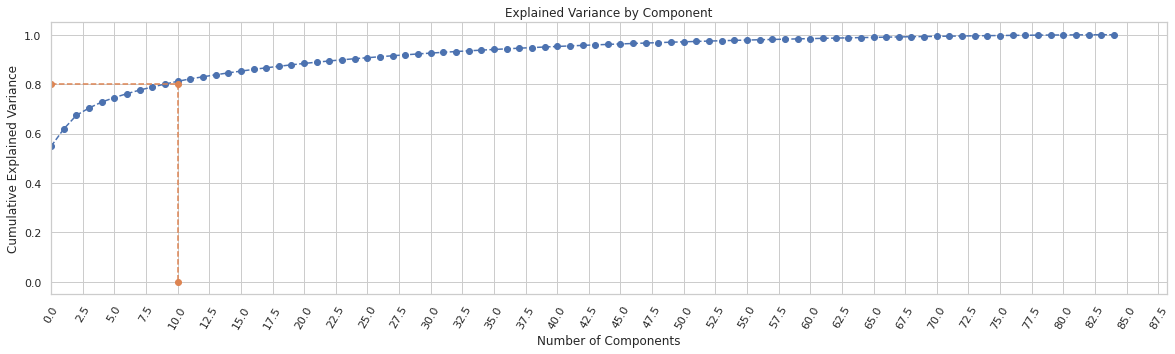

In [263]:
using_PAC = True

if using_PAC == True:
    pca = PCA()
    pca.fit(Features)
    #pca.explained_variance_ratio_
    plt.figure(figsize=(20,5))
    plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
    plt.locator_params(axis='x', nbins=39)
    plt.xlim(left=0)
    plt.xticks(rotation= 60)
    plt.title('Explained Variance by Component')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')


    #Let's aim to preserve around 80% of the variance.
    #Play around with the number of componens to see if a better number can be found. This is not the optimal value.__
    # decide about the number of components for percentage of data we want to keep
    number_of_comp = 10

    xpoints = [0, number_of_comp, number_of_comp]
    ypoints = [0.8, 0.8, 0]
    plt.plot(xpoints, ypoints, '--o')

    pca = PCA(n_components=10)

    # Fit the model to the data with the selected number of components
    pca.fit(Features)

    # saving the scores (to be used for clustering)
    pca_scores = pca.transform(Features)
else:
    pca_scores = Features

### Clustering

Let's write a function for all the clustering approaches and then choose the clustering method and call the function for the calculations

In [271]:
def silhouette_plot(silhouette_vals, chs, dbs, labels, ax):
    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for ii, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax.text(-0.05, (y_lower + y_upper) / 2, str(ii + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax.set_yticks([])
    ax.set_xlim([-0.1, 1])
    ax.set_xlabel('Silhouette coefficient values')
    ax.set_ylabel('Cluster labels')
    ax.set_title(f'silhouette score= {silhouette_vals.mean():0.3f}\ncalinski harabasz score = {chs:0.3f}\nDavis-Bouldin score = {dbs:0.3f}')



def clustering_calc(scores_pca, clustering_method='kmeans'):

    #################### Elbow method to find the best k value
    sse = []
    random_state_value = 42
    list_k = list(range(2, 50))

    if clustering_method in ('kmeans', 'kmedoids'):
        for k in list_k:
            if clustering_method=='kmeans':
                model = KMeans(init = "k-means++",n_clusters=k, random_state=random_state_value)
            elif clustering_method=='kmedoids':
                model = KMedoids(init = "k-medoids++",n_clusters=k, random_state=random_state_value)

            model.fit(scores_pca)
            sse.append(model.inertia_)

        # Plot sse against k
        plt.figure(figsize=(7, 5))
        plt.plot(list_k, sse, '-o', markersize=10, linewidth=4)
        plt.xlabel('Number of clusters [k]')
        plt.ylabel('SSE')

        plt.title(f'method={clustering_method}')
    elif clustering_method=='agglomerative':
        # Create linkage matrix and then plot the dendrogram
        # source: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
        def plot_dendrogram(model, **kwargs):
        
            # create the counts of samples under each node
            counts = np.zeros(model.children_.shape[0])
            n_samples = len(model.labels_)
            for i, merge in enumerate(model.children_):
                current_count = 0
                for child_idx in merge:
                    if child_idx < n_samples:
                        current_count += 1  # leaf node
                    else:
                        current_count += counts[child_idx - n_samples]
                counts[i] = current_count

            linkage_matrix = np.column_stack(
                [model.children_, model.distances_, counts]
            ).astype(float)

            # Plot the corresponding dendrogram
            fig, axes = plt.subplots(1, 1, figsize=(10, 5))
            dendrogram(linkage_matrix,ax=axes, orientation='top', **kwargs)

        agg_pca = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
        labels = agg_pca.fit_predict(scores_pca)
        # plot the top three levels of the dendrogram
        plot_dendrogram(agg_pca, truncate_mode="level", p=5)
        plt.title(f'{clustering_method}')


    ################### Silhouette coefficient plot

    if clustering_method in ('kmeans', 'kmedoids', 'agglomerative', 'birch'):
        fig, axs = plt.subplots(3, 3, figsize=(30, 15))
        axs = axs.ravel()
        for i, k in enumerate([2, 3, 4, 5, 6, 7, 8, 9, 10]):
            # Run the algorithm
            if clustering_method=='kmeans':
                model = KMeans(init = "k-means++",n_clusters=k, random_state=random_state_value)
            elif clustering_method=='kmedoids':
                model = KMedoids(init = "k-medoids++",n_clusters=k, random_state=random_state_value)
            elif clustering_method=='agglomerative':
                model = AgglomerativeClustering(n_clusters=k)
            elif clustering_method=='birch':
                model = Birch(
                    threshold=0.5,
                    branching_factor=50,
                    n_clusters=k
                )


            labels = model.fit_predict(scores_pca)
            
            # Q: Do I need to know the centroids?
            if clustering_method in ('kmeans', 'kmedoids'):
                centroids = model.cluster_centers_
            
            # Get silhouette score for samples
            silhouette_vals = silhouette_samples(scores_pca, labels)

            # Get Calinski-Harabasz score
            chs = metrics.calinski_harabasz_score(scores_pca, model.labels_)

            # Get Davies-Bouldin score
            dbs = metrics.davies_bouldin_score(scores_pca, model.labels_)

            
            silhouette_plot(silhouette_vals, chs, dbs, labels, axs[i])
        
        # set the spacing between subplots
        plt.subplots_adjust(wspace=0.4, hspace=0.5)

        plt.suptitle(f'{clustering_method}')
    elif clustering_method in ('OPTICS', 'DBSCAN'):
        
        if clustering_method=='DBSCAN':
            fig, axs = plt.subplots(3, 3, figsize=(30, 15))
            axs = axs.ravel()
        
            for i, min_sample_value in enumerate([10, 11, 12, 13, 14, 15, 16, 17, 18]):

                # 1. check this paper: "DBSCAN Revisited, Revisited: Why and How You Should (Still) Use DBSCAN"

                # 2. some explanations for minPt from here: https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan
                #minPts is selected based on the domain knowledge. 
                #If you do not have domain understanding, a rule of thumb is to 
                #derive minPts from the number of dimensions D in the data set. 
                #minPts >= D + 1. For 2D data, take minPts = 4. 
                #For larger datasets, with much noise, it suggested to go with minPts = 2 * D.

                # 3. Also see https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

                nearest_neighbors = NearestNeighbors(n_neighbors=min_sample_value+1)
                neighbors = nearest_neighbors.fit(scores_pca)
                distances, indices = neighbors.kneighbors(scores_pca)

                distances = np.sort(distances[:,min_sample_value], axis=0)
                
                # based on "https://ieeexplore.ieee.org/document/5961514"
                d = np.arange(len(distances))
                knee = KneeLocator(d, distances, S=1, direction='increasing', curve='convex')
                # --- plotting the knee plot will mess up the plots for Silhouette coefficient !!
                #---------------------------------------------------
                # trying this approach from here: https://stackoverflow.com/questions/17458580/embedding-small-plots-inside-subplots-in-matplotlib
                #inset_axes_set = inset_axes(axs[i],
                #    width="30%", # width = 30% of parent_bbox
                #    height=1., # height : 1 inch
                #    loc=1)
                #knee.plot_knee()    
                #plt.xlabel("Points")
                #plt.ylabel("Distance")
                #plt.show()
                #print(distances[knee.knee])

                # using the most optimal value based on the elbow method
                eps_value = distances[knee.knee]
                
                model = DBSCAN(eps=eps_value, min_samples=min_sample_value)
            
                labels = model.fit_predict(scores_pca)
                # Get silhouette samples
                silhouette_vals = silhouette_samples(scores_pca, labels)

                # Get Calinski-Harabasz score
                chs = metrics.calinski_harabasz_score(scores_pca, labels)

                # Get Davies-Bouldin score
                dbs = metrics.davies_bouldin_score(scores_pca, labels)

                silhouette_plot(silhouette_vals, chs, dbs, labels, axs[i])
                
            # set the spacing between subplots
            plt.subplots_adjust(wspace=0.4, hspace=0.5)

            plt.suptitle(f'{clustering_method}')

        elif clustering_method=='OPTICS':
            #print(clustering_method)
            
            xi_values = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.02]

            fig, axs = plt.subplots(len(xi_values), 2, figsize=(20, 30))
            axs = axs.ravel()
        
            
            min_sample_value = 4
            for i, xi_value in enumerate(xi_values):
                # use (xi_value*100)% drop in density to determine each cluster
                model = OPTICS(min_samples=min_sample_value, xi=xi_value)

                labels = model.fit_predict(scores_pca)
                # Get silhouette samples
                silhouette_vals = silhouette_samples(scores_pca, labels)

                # Get Calinski-Harabasz score
                chs = metrics.calinski_harabasz_score(scores_pca, labels)

                # Get Davies-Bouldin score
                dbs = metrics.davies_bouldin_score(scores_pca, labels)

                # Silhouette plot
                silhouette_plot(silhouette_vals, chs, dbs, labels, axs[2*(i+1)-1])

                # reachability plot
                #based on https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py
                #
                # Explanation:
                # Each trough in the plot corresponds to a region of high density, while each spike indicates a separation of these 
                # regions by a region of low density.
                # define a particular steepness in the reachability plot as indicative of the start and end of a cluster. 
                # We can define the start of a cluster as when we have a downward slope of at least this steepness, and its 
                # end as when we have an upward slope of at least this steepness. The method we’ll use later defines the steepness 
                # as 1 – ξ (xi, pronounced “zy,” “sigh,” or “kzee,” depending on your preference and mathematics teacher), 
                # where the reachability of two successive cases must change by a factor of 1 – ξ. 
                # When we have a downward slope that meets this steepness criterion, the start of a cluster is defined; 
                # and when we have an upward slope that meets this steepness, the end of the cluster is defined.
                # see this book chapter: https://livebook.manning.com/book/machine-learning-for-mortals-mere-and-otherwise/chapter-18/90


                space = np.arange(len(scores_pca))
                reachability = model.reachability_[model.ordering_]
                labels = model.labels_[model.ordering_]

                cycol = cycle('bgrcmk')
                for klass in range(len(model.labels_)):
                    Xk = space[labels == klass]
                    Rk = reachability[labels == klass]
                    axs[2*i].plot(Xk, Rk, '-o' ,color=next(cycol), lw='2')
        
                axs[2*i].plot(space[labels == -1], reachability[labels == -1], ".", color=next(cycol))
                axs[2*i].set_ylabel("Reachability (epsilon distance)")
                axs[2*i].set_xlabel("Ordered case number")
                axs[2*i].set_title(f"Reachability Plot with xi={xi_value}")
            
            # set the spacing between subplots
            plt.subplots_adjust(wspace=0.1, hspace=0.5)

    return model, silhouette_vals
#plt.savefig('Silhouette.png',bbox_inches='tight',dpi=300)

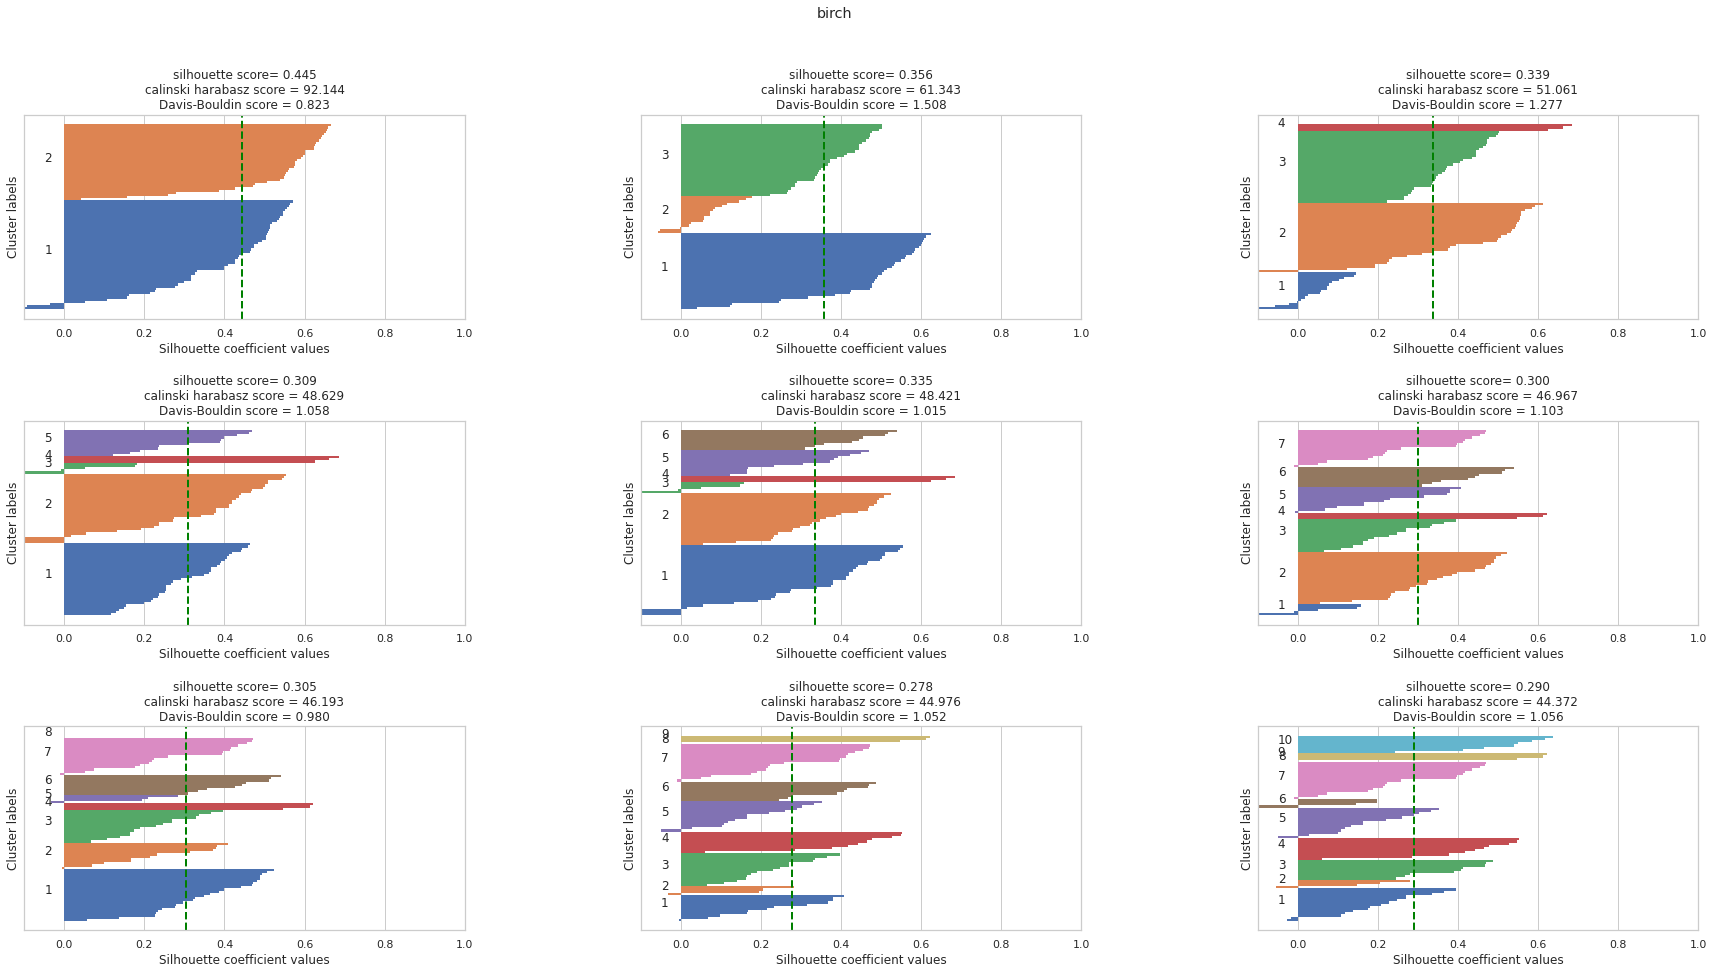

In [277]:
# options: 'kmeans', 'kmedoids', 'agglomerative', 'DBSCAN', 'OPTICS', 'birch'
model, slm = clustering_calc(pca_scores, clustering_method='birch')

<font color='red'>Next steps:</font>
1. look into _Birch_ method and see if we can tune it better